# Prepare data for forecasting

## Introduction

In this notebook, I prepare the data for forecasting.  Specifically, I:

* Clean the data,
* Transform the data set to remove stationarity, and
* Split the data into training and test sets.

## Set up

In [1]:
# Import key libraries and set some defaults

import numpy as np
import pandas as pd
from pandas.plotting import lag_plot

import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.gridspec as gridspec

# Need converters for matplotlib to use dates in time plot
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.graphics.gofplots import qqplot

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [2]:
# Set some Seaborn defaults
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('muted')

In [3]:
import my_func
import importlib  # To allow reload while debugging .py files

In [4]:
# Eliminate some future warnings
import warnings
warnings.simplefilter(action='ignore')

## Load data

In [5]:
prep_sj = pd.read_pickle('../sb_cap2_nb-99_data/clean_train_forecast-variable_sj.pickle')
prep_iq = pd.read_pickle('../sb_cap2_nb-99_data/clean_train_forecast-variable_iq.pickle')

## Clean:  drop irrelvant columns

In [6]:
prep_sj.drop(['year', 'month', 'weekofyear'], axis=1, inplace=True)
prep_iq.drop(['year', 'month', 'weekofyear'], axis=1, inplace=True)

assert len(prep_sj.columns) == 1

## Clean:  Drop suspicious values from Iquitos

In [7]:
index_of_rows_to_drop = prep_iq.loc[prep_iq.index < '2002-01-01'].index
prep_iq.drop(index_of_rows_to_drop, axis=0, inplace=True)

assert prep_iq.index.min() >= pd.to_datetime('2001-12-31')

## Tranform via lag-1 difference

### Define functions - lag-n differencing

In [8]:
def tranform_via_diff(df, diff_periods):
    """Returns a new data frames that's tranformed via a diff of given periods"""
    
    diff_df = df.copy()
    diff_df['diff'] = diff_df['total_cases'].diff(periods=diff_periods)
    diff_df.drop('total_cases', axis=1, inplace=True)
    diff_df.rename(columns = {'diff':'total_cases'}, inplace = True)
    diff_df.drop(df.index[0:diff_periods], inplace=True) # Drop initial NaN where no diff
    
    return diff_df

In [9]:
# def tranform_back_from_diff(diff_df, diff_periods, source_df):
#     """Returns a new data frames that's the un-tranformed data after a diff"""

#     transf_back_df_head = source_df.iloc[0:diff_periods].copy()    
#     transf_back_df = transf_back_df_head.append(diff_df)
#     transf_back_df['temp'] = transf_back_df['total_cases']
#     for i in range(len(transf_back_df)):
#         value = transf_back_df['total_cases'].iloc[0:(i+1)].sum() #BUG:  THIS ONLY WORKS FOR 1-lag
#         transf_back_df['temp'][i] = value
#     transf_back_df.drop(['total_cases'], axis=1, inplace=True)   
#     transf_back_df.rename(columns = {'temp': 'total_cases'}, inplace=True)
    
#     return transf_back_df

### Transform - lag-1 differencing

In [10]:
prep_diff_1_sj = tranform_via_diff(prep_sj, 1)
prep_diff_1_iq = tranform_via_diff(prep_iq, 1)

In [11]:
# prep_undiff_1_sj = tranform_back_from_diff(prep_diff_1_sj, 1, prep_sj)
# prep_undiff_1_iq = tranform_back_from_diff(prep_diff_1_iq, 1, prep_iq)

In [12]:
# assert prep_sj['total_cases'].sum() == prep_undiff_1_sj['total_cases'].sum()

### Examine for stationary - lag-1 differencing - San Juan

In [13]:
my_func.stationarity_test_via_simple_calcs(prep_diff_1_sj, 'San Juan')

Here's a quick test for stationarity.
Most likley, a time series is NOT stationary if . . . 

. . . the mean of each half of the data isn't roughly the same.
    Are the means of 0.027837259100642397 and -0.02564102564102564 roughly equal?
    No, for the San Juan data, the second half is not within 5% of first half.

. . . if the variance of each half of the data isn't roughly the same.
    Are the variances of 293.413386514231 and 79.03146104430898 roughly equal?
    No,  for the San Juan data, the second half is not within 5% of first half.


('mean_no', 'var_no')

Decomposition of weekly cases into trend, seasonality and residual via a naive, additive model in San Juan


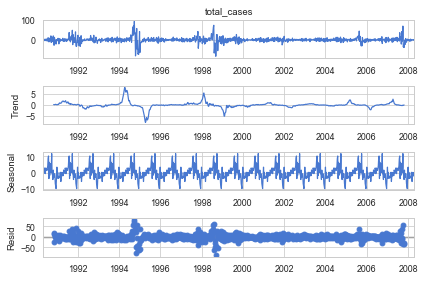

In [14]:
my_func.stationarity_test_via_seasonal_decompose(prep_diff_1_sj, 'San Juan')

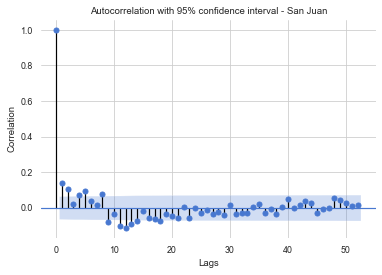

In [15]:
my_func.stationarity_test_via_acf_graph(prep_diff_1_sj, 'San Juan')

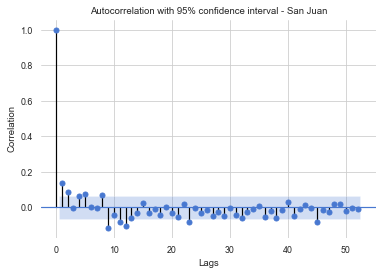

In [16]:
my_func.stationarity_test_via_pacf_graph(prep_diff_1_sj, 'San Juan')

In [17]:
my_func.stationarity_test_via_adf(prep_diff_1_sj, 'San Juan')

Here are the resutls of testing using ADF in San Juan

ADF test stat: 	            -5.92737
P value: 	             0.00000
Lags used: 	            52.00000
Observations: 	           882.00000
    1%: 	            -3.43779
    5%: 	            -2.86482
    10%: 	            -2.56852

Applying the test results
My null is:  there is a unit root, which means not stationary
At significance level of 5%, my thinking is:
	 P-value is less than critical value.
	 Reject null.  Accept alternative.
	 No satistically signifcant unit root
	 That is, this time series is stationary


In [18]:
my_func.stationarity_test_via_kpss(prep_diff_1_sj, 'San Juan')

Here are the restuls of testing using KPSS in San Juan

KPSS stat: 	             0.03887
P value: 	             0.10000
Lags used: 	            52.00000
    10%: 	             0.34700
    5%: 	             0.46300
    2.5%: 	             0.57400
    1%: 	             0.73900

Applying the test results
My null is:  there is no unit root, which means stationary
At significance level of 5%, my thinking is:
	 P-value is greater than or equal to critical value
	 Do not reject null.  Do not accept alternative
	 Cannot conclude there is no stat. sig. unit root.
	 That is, this time series is likely stationary.


### Examine for stationary - lag-1 differencing - Iquitos

In [19]:
my_func.stationarity_test_via_simple_calcs(prep_diff_1_iq, 'Iquitos')

Here's a quick test for stationarity.
Most likley, a time series is NOT stationary if . . . 

. . . the mean of each half of the data isn't roughly the same.
    Are the means of 0.03636363636363636 and -0.03619909502262444 roughly equal?
    No, for the Iquitos data, the second half is not within 5% of first half.

. . . if the variance of each half of the data isn't roughly the same.
    Are the variances of 95.55118306351154 and 42.935047305635564 roughly equal?
    No,  for the Iquitos data, the second half is not within 5% of first half.


('mean_no', 'var_no')

Decomposition of weekly cases into trend, seasonality and residual via a naive, additive model in Iquitos


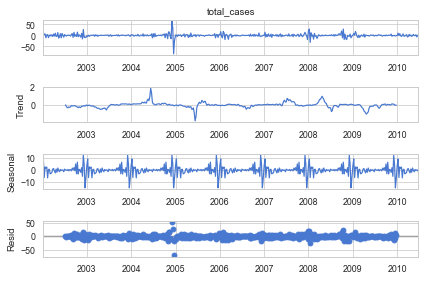

In [20]:
my_func.stationarity_test_via_seasonal_decompose(prep_diff_1_iq, 'Iquitos')

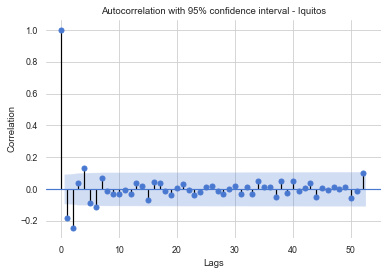

In [21]:
my_func.stationarity_test_via_acf_graph(prep_diff_1_iq, 'Iquitos')

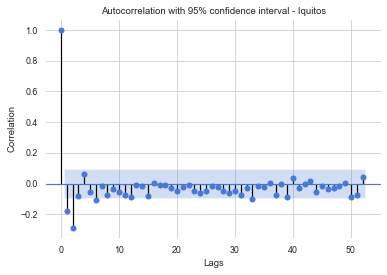

In [22]:
my_func.stationarity_test_via_pacf_graph(prep_diff_1_iq, 'Iquitos')

In [23]:
my_func.stationarity_test_via_adf(prep_diff_1_iq, 'Iquitos')

Here are the resutls of testing using ADF in Iquitos

ADF test stat: 	            -4.28000
P value: 	             0.00048
Lags used: 	            52.00000
Observations: 	           388.00000
    1%: 	            -3.44732
    5%: 	            -2.86902
    10%: 	            -2.57075

Applying the test results
My null is:  there is a unit root, which means not stationary
At significance level of 5%, my thinking is:
	 P-value is less than critical value.
	 Reject null.  Accept alternative.
	 No satistically signifcant unit root
	 That is, this time series is stationary


In [24]:
my_func.stationarity_test_via_kpss(prep_diff_1_iq, 'Iquitos')

Here are the restuls of testing using KPSS in Iquitos

KPSS stat: 	             0.06863
P value: 	             0.10000
Lags used: 	            52.00000
    10%: 	             0.34700
    5%: 	             0.46300
    2.5%: 	             0.57400
    1%: 	             0.73900

Applying the test results
My null is:  there is no unit root, which means stationary
At significance level of 5%, my thinking is:
	 P-value is greater than or equal to critical value
	 Do not reject null.  Do not accept alternative
	 Cannot conclude there is no stat. sig. unit root.
	 That is, this time series is likely stationary.


### Transform - lag-52 (seasonal) differencing

In [25]:
prep_diff_52_sj = tranform_via_diff(prep_sj, 52)
prep_diff_52_iq = tranform_via_diff(prep_iq, 52)

### Examine for stationary - lag-52 differencing - San Juan

In [26]:
my_func.stationarity_test_via_simple_calcs(prep_diff_52_sj, 'San Juan')

Here's a quick test for stationarity.
Most likley, a time series is NOT stationary if . . . 

. . . the mean of each half of the data isn't roughly the same.
    Are the means of 1.6855203619909502 and -0.2081447963800905 roughly equal?
    No, for the San Juan data, the second half is not within 5% of first half.

. . . if the variance of each half of the data isn't roughly the same.
    Are the variances of 9438.869132268306 and 1035.3443326048366 roughly equal?
    No,  for the San Juan data, the second half is not within 5% of first half.


('mean_no', 'var_no')

Decomposition of weekly cases into trend, seasonality and residual via a naive, additive model in San Juan


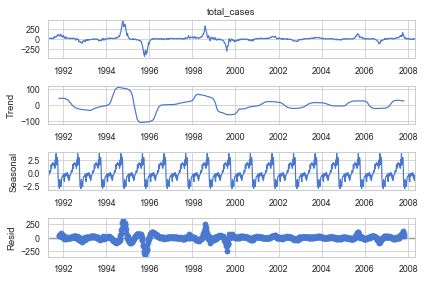

In [27]:
my_func.stationarity_test_via_seasonal_decompose(prep_diff_52_sj, 'San Juan')

In [28]:
my_func.stationarity_test_via_adf(prep_diff_52_sj, 'San Juan')

Here are the resutls of testing using ADF in San Juan

ADF test stat: 	            -3.78108
P value: 	             0.00311
Lags used: 	            52.00000
Observations: 	           831.00000
    1%: 	            -3.43824
    5%: 	            -2.86502
    10%: 	            -2.56863

Applying the test results
My null is:  there is a unit root, which means not stationary
At significance level of 5%, my thinking is:
	 P-value is less than critical value.
	 Reject null.  Accept alternative.
	 No satistically signifcant unit root
	 That is, this time series is stationary


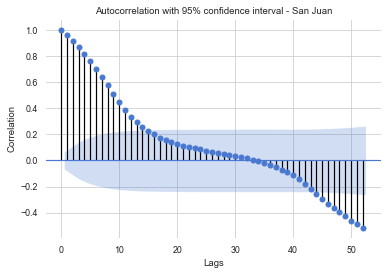

In [29]:
my_func.stationarity_test_via_acf_graph(prep_diff_52_sj, 'San Juan')

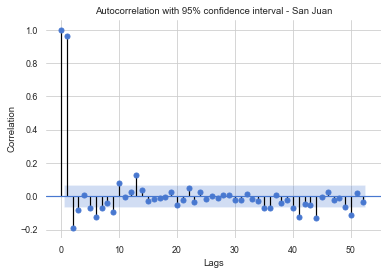

In [30]:
my_func.stationarity_test_via_pacf_graph(prep_diff_52_sj, 'San Juan')

In [31]:
my_func.stationarity_test_via_kpss(prep_diff_52_sj, 'San Juan')

Here are the restuls of testing using KPSS in San Juan

KPSS stat: 	             0.03217
P value: 	             0.10000
Lags used: 	            52.00000
    10%: 	             0.34700
    5%: 	             0.46300
    2.5%: 	             0.57400
    1%: 	             0.73900

Applying the test results
My null is:  there is no unit root, which means stationary
At significance level of 5%, my thinking is:
	 P-value is greater than or equal to critical value
	 Do not reject null.  Do not accept alternative
	 Cannot conclude there is no stat. sig. unit root.
	 That is, this time series is likely stationary.


### Examine for stationary - lag-52 differencing - Iquitos

In [32]:
my_func.stationarity_test_via_simple_calcs(prep_diff_52_iq, 'Iquitos')

Here's a quick test for stationarity.
Most likley, a time series is NOT stationary if . . . 

. . . the mean of each half of the data isn't roughly the same.
    Are the means of -1.3435897435897435 and -0.7487179487179487 roughly equal?
    No, for the Iquitos data, the second half is not within 5% of first half.

. . . if the variance of each half of the data isn't roughly the same.
    Are the variances of 305.95865715040964 and 219.44684113137774 roughly equal?
    No,  for the Iquitos data, the second half is not within 5% of first half.


('mean_no', 'var_no')

Decomposition of weekly cases into trend, seasonality and residual via a naive, additive model in Iquitos


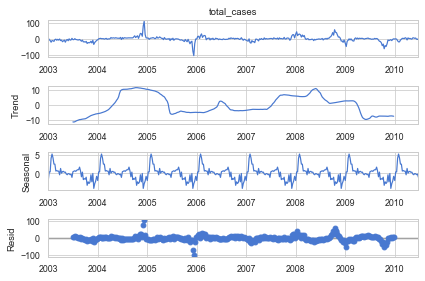

In [33]:
my_func.stationarity_test_via_seasonal_decompose(prep_diff_52_iq, 'Iquitos')

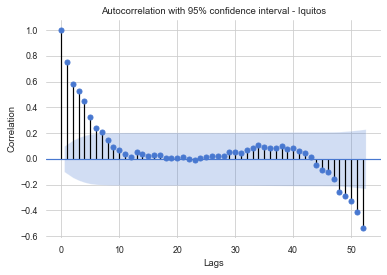

In [34]:
my_func.stationarity_test_via_acf_graph(prep_diff_52_iq, 'Iquitos')

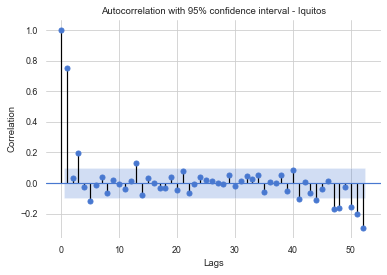

In [35]:
my_func.stationarity_test_via_pacf_graph(prep_diff_52_iq, 'Iquitos')

In [36]:
my_func.stationarity_test_via_adf(prep_diff_52_iq, 'Iquitos')

Here are the resutls of testing using ADF in Iquitos

ADF test stat: 	            -4.21924
P value: 	             0.00061
Lags used: 	            52.00000
Observations: 	           337.00000
    1%: 	            -3.44990
    5%: 	            -2.87015
    10%: 	            -2.57136

Applying the test results
My null is:  there is a unit root, which means not stationary
At significance level of 5%, my thinking is:
	 P-value is less than critical value.
	 Reject null.  Accept alternative.
	 No satistically signifcant unit root
	 That is, this time series is stationary


In [37]:
my_func.stationarity_test_via_kpss(prep_diff_52_iq, 'Iquitos')

Here are the restuls of testing using KPSS in Iquitos

KPSS stat: 	             0.07172
P value: 	             0.10000
Lags used: 	            52.00000
    10%: 	             0.34700
    5%: 	             0.46300
    2.5%: 	             0.57400
    1%: 	             0.73900

Applying the test results
My null is:  there is no unit root, which means stationary
At significance level of 5%, my thinking is:
	 P-value is greater than or equal to critical value
	 Do not reject null.  Do not accept alternative
	 Cannot conclude there is no stat. sig. unit root.
	 That is, this time series is likely stationary.


## Transform via log(x+1)

### Define functions - log(x+1)

In [38]:
def tranform_via_log_x_plus_1(df):
    """Returns a new data frames that's tranformed via log(x+1)"""
    
    df_log = df.copy()
    df_log['log1p'] = np.log1p(df_log['total_cases'])
    df_log.drop('total_cases', axis=1, inplace=True)
    df_log.rename(columns = {'log1p':'total_cases'}, inplace = True)
    
    return df_log

In [39]:
def tranform_back_from_log_x_plus_1(df):
    """Returns a new data frames that's tranformed back from log(x+1)"""
    
    df_log = df.copy()
    df_log['expm1'] = np.expm1(df_log['total_cases'])
    df_log.drop('total_cases', axis=1, inplace=True)
    df_log.rename(columns = {'expm1':'total_cases'}, inplace = True)
    
    return df_log

### Transform - log(x+1)

In [40]:
prep_log_sj = tranform_via_log_x_plus_1(prep_sj)
prep_log_iq = tranform_via_log_x_plus_1(prep_iq)

### Examine for stationary - log(x+1) - San Juan

In [41]:
my_func.stationarity_test_via_simple_calcs(prep_log_sj, 'San Juan')

Here's a quick test for stationarity.
Most likley, a time series is NOT stationary if . . . 

. . . the mean of each half of the data isn't roughly the same.
    Are the means of 3.4058197388693885 and 2.5992464086214184 roughly equal?
    No, for the San Juan data, the second half is not within 5% of first half.

. . . if the variance of each half of the data isn't roughly the same.
    Are the variances of 0.9077485313822443 and 0.9010325411707001 roughly equal?
    Yes, for the San Juan data, the second half is withing 5% of first.


('mean_no', 'var_yes')

Decomposition of weekly cases into trend, seasonality and residual via a naive, additive model in San Juan


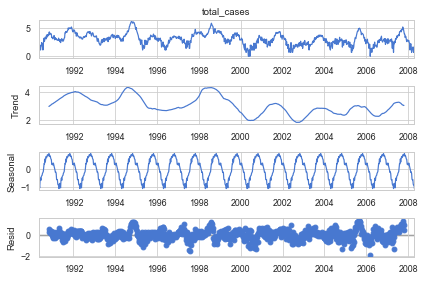

In [42]:
my_func.stationarity_test_via_seasonal_decompose(prep_log_sj, 'San Juan')

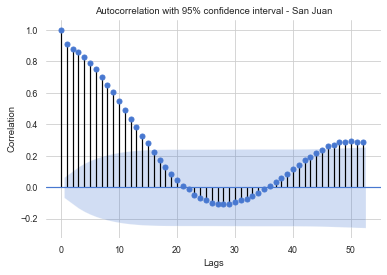

In [43]:
my_func.stationarity_test_via_acf_graph(prep_log_sj, 'San Juan')

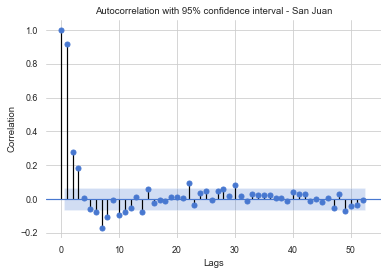

In [44]:
my_func.stationarity_test_via_pacf_graph(prep_log_sj, 'San Juan')

In [45]:
my_func.stationarity_test_via_adf(prep_log_sj, 'San Juan')

Here are the resutls of testing using ADF in San Juan

ADF test stat: 	            -2.95828
P value: 	             0.03898
Lags used: 	            52.00000
Observations: 	           883.00000
    1%: 	            -3.43778
    5%: 	            -2.86482
    10%: 	            -2.56852

Applying the test results
My null is:  there is a unit root, which means not stationary
At significance level of 5%, my thinking is:
	 P-value is less than critical value.
	 Reject null.  Accept alternative.
	 No satistically signifcant unit root
	 That is, this time series is stationary


In [46]:
my_func.stationarity_test_via_kpss(prep_log_sj, 'San Juan')

Here are the restuls of testing using KPSS in San Juan

KPSS stat: 	             0.56834
P value: 	             0.02628
Lags used: 	            52.00000
    10%: 	             0.34700
    5%: 	             0.46300
    2.5%: 	             0.57400
    1%: 	             0.73900

Applying the test results
My null is:  there is no unit root, which means stationary
At significance level of 5%, my thinking is:
	 P-value is less than critical value.
	 Reject null.  Accept alternative.
	 Yes, there is a statistically signifcant unit root
	 That is, this time series is NOT stationary


### Examine for stationary - log(x+1) - Iquitos

In [47]:
my_func.stationarity_test_via_simple_calcs(prep_log_iq, 'Iquitos')

Here's a quick test for stationarity.
Most likley, a time series is NOT stationary if . . . 

. . . the mean of each half of the data isn't roughly the same.
    Are the means of 1.8987850784678384 and 1.8188047062943447 roughly equal?
    Yes,  for the Iquitos data, the second half is withing 5% of first.

. . . if the variance of each half of the data isn't roughly the same.
    Are the variances of 0.8630328236623818 and 0.8756322670819509 roughly equal?
    Yes, for the Iquitos data, the second half is withing 5% of first.


('mean_yes', 'var_yes')

Decomposition of weekly cases into trend, seasonality and residual via a naive, additive model in Iquitos


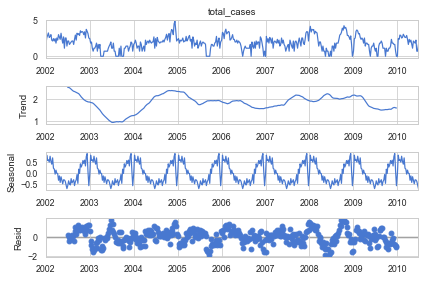

In [48]:
my_func.stationarity_test_via_seasonal_decompose(prep_log_iq, 'Iquitos')

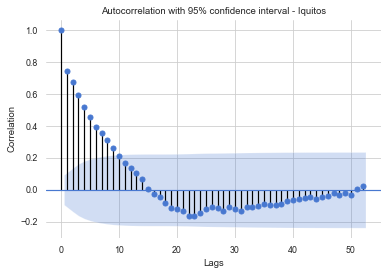

In [49]:
my_func.stationarity_test_via_acf_graph(prep_log_iq, 'Iquitos')

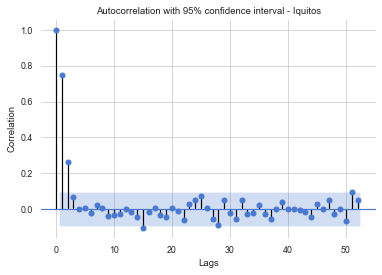

In [50]:
my_func.stationarity_test_via_pacf_graph(prep_log_iq, 'Iquitos')

In [51]:
my_func.stationarity_test_via_adf(prep_log_iq, 'Iquitos')

Here are the resutls of testing using ADF in Iquitos

ADF test stat: 	            -3.04826
P value: 	             0.03063
Lags used: 	            52.00000
Observations: 	           389.00000
    1%: 	            -3.44727
    5%: 	            -2.86900
    10%: 	            -2.57074

Applying the test results
My null is:  there is a unit root, which means not stationary
At significance level of 5%, my thinking is:
	 P-value is less than critical value.
	 Reject null.  Accept alternative.
	 No satistically signifcant unit root
	 That is, this time series is stationary


In [52]:
my_func.stationarity_test_via_kpss(prep_log_iq, 'Iquitos')

Here are the restuls of testing using KPSS in Iquitos

KPSS stat: 	             0.05126
P value: 	             0.10000
Lags used: 	            52.00000
    10%: 	             0.34700
    5%: 	             0.46300
    2.5%: 	             0.57400
    1%: 	             0.73900

Applying the test results
My null is:  there is no unit root, which means stationary
At significance level of 5%, my thinking is:
	 P-value is greater than or equal to critical value
	 Do not reject null.  Do not accept alternative
	 Cannot conclude there is no stat. sig. unit root.
	 That is, this time series is likely stationary.


## Tranform:  Box-Cox

In [53]:
# Scipy's boxcox function requies values > 0

In [54]:
def transform_with_boxcox_check_lambda_without_zero_rows(df):
    """Tells the number of zero rows in dataframe and BoxCox lambda without those zeros"""
    
    nonzero_df = df[df['total_cases'] != 0].copy()
    print('There are {} rows with 0 total cases'.format(len(df) - len(nonzero_df)))
    
    nonzero_bc, nonzero_lam = boxcox(nonzero_df['total_cases'])
    print('The BoxCox lambda without the total cases  is {}'.format(nonzero_lam)) 

In [55]:
transform_with_boxcox_check_lambda_without_zero_rows(prep_sj)

There are 4 rows with 0 total cases
The BoxCox lambda without the total cases  is 0.011479749317317623


In [56]:
transform_with_boxcox_check_lambda_without_zero_rows(prep_iq)

There are 32 rows with 0 total cases
The BoxCox lambda without the total cases  is -0.023325118136650076


In [57]:
# Calculate boxcox after a shift of x+1

In [58]:
def transform_with_boxcox_x_plus_1(df):
    
    bc_df = df.copy()
    bc_df['x+1'] = bc_df['total_cases'] + 1
    bc_df['bc(x+1)'], bc_lam = boxcox(bc_df['x+1'])
    bc_df.drop(['total_cases', 'x+1'], axis=1, inplace=True)
    bc_df.rename(columns = {'bc(x+1)':'total_cases'}, inplace = True)
    
    return bc_df, bc_lam

In [59]:
prep_bc_sj, prep_bc_lambda_sj = transform_with_boxcox_x_plus_1(prep_sj)

print('The BoxCox lambda for San Juan after an x+1 shift is {}'.format(prep_bc_lambda_sj))

The BoxCox lambda for San Juan after an x+1 shift is -0.03465614963284881


In [60]:
prep_bc_iq, prep_bc_lambda_iq = transform_with_boxcox_x_plus_1(prep_iq)

print('The BoxCox lambda for Iquitos after an x+1 shift is {}'.format(prep_bc_lambda_iq))

The BoxCox lambda for Iquitos after an x+1 shift is 0.0036517562988525746


### Examine for stationary - box cox (x+1) - San Juan

In [61]:
my_func.stationarity_test_via_simple_calcs(prep_bc_sj, 'San Juan')

Here's a quick test for stationarity.
Most likley, a time series is NOT stationary if . . . 

. . . the mean of each half of the data isn't roughly the same.
    Are the means of 3.19858253761075 and 2.4713810540003522 roughly equal?
    No, for the San Juan data, the second half is not within 5% of first half.

. . . if the variance of each half of the data isn't roughly the same.
    Are the variances of 0.7129249838845638 and 0.7522998829708731 roughly equal?
    No,  for the San Juan data, the second half is not within 5% of first half.


('mean_no', 'var_no')

Decomposition of weekly cases into trend, seasonality and residual via a naive, additive model in San Juan


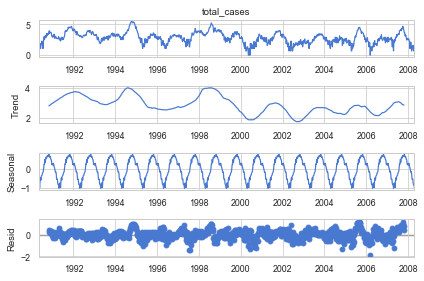

In [62]:
my_func.stationarity_test_via_seasonal_decompose(prep_bc_sj, 'San Juan')

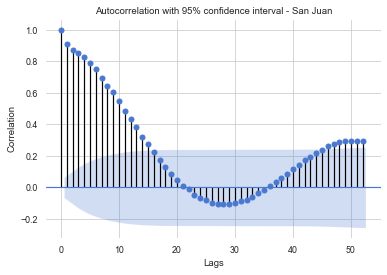

In [63]:
my_func.stationarity_test_via_acf_graph(prep_bc_sj, 'San Juan')

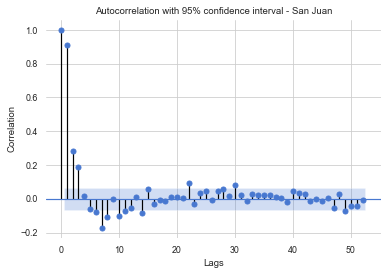

In [64]:
my_func.stationarity_test_via_pacf_graph(prep_bc_sj, 'San Juan')

In [65]:
my_func.stationarity_test_via_adf(prep_bc_sj, 'San Juan')

Here are the resutls of testing using ADF in San Juan

ADF test stat: 	            -2.94450
P value: 	             0.04041
Lags used: 	            52.00000
Observations: 	           883.00000
    1%: 	            -3.43778
    5%: 	            -2.86482
    10%: 	            -2.56852

Applying the test results
My null is:  there is a unit root, which means not stationary
At significance level of 5%, my thinking is:
	 P-value is less than critical value.
	 Reject null.  Accept alternative.
	 No satistically signifcant unit root
	 That is, this time series is stationary


In [66]:
my_func.stationarity_test_via_kpss(prep_bc_sj, 'San Juan')

Here are the restuls of testing using KPSS in San Juan

KPSS stat: 	             0.57473
P value: 	             0.02493
Lags used: 	            52.00000
    10%: 	             0.34700
    5%: 	             0.46300
    2.5%: 	             0.57400
    1%: 	             0.73900

Applying the test results
My null is:  there is no unit root, which means stationary
At significance level of 5%, my thinking is:
	 P-value is less than critical value.
	 Reject null.  Accept alternative.
	 Yes, there is a statistically signifcant unit root
	 That is, this time series is NOT stationary


## Split data

Here's I use a "simple" method to split my time series into one training set and one test set, with the "earlier" part of the series to training and the "later" the test.  

There are time-series cross validation methods.  For example, scikit-learn's TimeSeriesSplit splits a time series into multiple groups, each with a different length training set of earlier data and training set of a fixed about of later data.  The concept is (somewhat) similar to folds.  That is, I could create an "inner" test and validation set for hyperparameter tuning as well as an "outer" testing loop using the folds to create average scores.

In [67]:
def split_time_series_given_percentage(df, train_pct):
    """Split the given time series into train and test based on the given percentage"""

    split = int(len(df) * train_pct)
    train = df.iloc[0:split]
    test = df.iloc[split:]
    return train, test

In [68]:
def graph_time_series_split_into_test_and_train(train, test, city):
    """Graph the time series plit into train and test"""
    
    # Add the train-test information back to the dataframe
    train_temp = train.copy()
    train_temp['Split'] = 'train'
    test_temp = test.copy()
    test_temp['Split'] = 'test'
    df_temp = pd.concat([train_temp, test_temp], axis=0)
    
    # Reset the index to keep Seaborn happy
    df_temp.reset_index(inplace=True)

    # Graph the data set  
    g = plt.figure(figsize=(9, 3), dpi=100)
    g = sns.lineplot(data=df_temp, x='week_start_date', y='total_cases', hue='Split')
    g = plt.xlabel('Year')
    g = plt.ylabel('Cases per week')
    g = plt.title('Test-train split for {}'.format(city))
    g = plt.legend(loc=2, prop={'size': 8})
    g = plt.box(on=None)

In [69]:
# Split the data - San Juan
train_sj, test_sj = split_time_series_given_percentage(prep_sj, .75)

In [ ]:
# Graph the split - San Juan 
graph_time_series_split_into_test_and_train(train_sj, test_sj, 'San Juan')

In [72]:
# Split the data - Iquitos
train_iq, test_iq = split_time_series_given_percentage(prep_iq, .75)

In [ ]:
# Graph the split - Iquitos
graph_time_series_split_into_test_and_train(train_iq, test_iq, 'Iquitos')

### Split log-tranformed data

In [ ]:
# Split the data - San Juan
train_log_sj, test_log_sj = split_time_series_given_percentage(prep_log_sj, .75)

In [ ]:
# Split the data - Iquitos
train_log_iq, test_log_iq = split_time_series_given_percentage(prep_log_iq, .75)

In [ ]:
# # Graph the split - Iquitos
# graph_time_series_split_into_test_and_train(train_log_iq, test_log_iq, 'San Juan')
# print("NOTE:  This is the log of cases per week")

# Other prep for forecastings

In [ ]:
# Create dataframe to hold my scores

score_df = pd.DataFrame(columns=['approach', 'variation', 'summary', 'city', 'data', 'transform', 'rmse', 'mae'])

# # Test
# score_df

## Save dataframes

In [ ]:
prep_sj.to_pickle('../sb_cap2_nb-99_data/prep_sj.pickle')
prep_iq.to_pickle('../sb_cap2_nb-99_data/prep_iq.pickle')
train_sj.to_pickle('../sb_cap2_nb-99_data/prep_train_sj.pickle')
test_sj.to_pickle('../sb_cap2_nb-99_data/prep_test_sj.pickle')
train_iq.to_pickle('../sb_cap2_nb-99_data/prep_train_iq.pickle')
test_iq.to_pickle('../sb_cap2_nb-99_data/prep_test_iq.pickle')

prep_log_sj.to_pickle('../sb_cap2_nb-99_data/prep_log_sj.pickle')
prep_log_iq.to_pickle('../sb_cap2_nb-99_data/prep_log_iq.pickle')
train_log_sj.to_pickle('../sb_cap2_nb-99_data/prep_log_train_sj.pickle')
test_log_sj.to_pickle('../sb_cap2_nb-99_data/prep_log_test_sj.pickle')
train_log_iq.to_pickle('../sb_cap2_nb-99_data/prep_log_train_iq.pickle')
test_log_iq.to_pickle('../sb_cap2_nb-99_data/prep_log_test_iq.pickle')

score_df.to_pickle('../sb_cap2_nb-99_data/scores_after_nbk_4.pickle')

## Commentary

To prepare for forecasting, I clean, transform and split the data.

#### Clean

Generally, this data set does not require much cleaning.  I only need to:

* **Drop irrelevant columns.**  Given my focus on univariate forecasting, I only require a date--the index--and a forecast variable--total cases.  I drop the other columns.

* **Drop suspect values in Iquitos.**  In Iquitos, the first two years--2000 and 2001--have almost no cases, little variance and no seasonality.  Then, right at the start of the 2002 calendar year, total cases start their normal pattern.  These odd values plus the clean break at the start of a calendar year makes those first two years suspect; maybe cases were measured differently in 2000 and 2001?  I drop those cases.

#### Transform

Many time-series models require stationary data.  Stationary time series's properties do not depend on the time observed.  Generally, they don't have trends or seasonality (although they can be cyclic across non-regular time frames).  More specifically, stationary time series have:  a constant mean, a constant variance, a constant autocorrelation structure (current value being dependent on past value) and no periodic components.

In my EDA, I discovered that San Juan and Iquitos are not stationary.  Accordingly, they need to be transformed.  A common technique is differencing--looking at the changes in, not the value of, the forecast variable.  Often, the differences are calculated over 1-lag period. Sometimes, the differences are calculated across seasons, which in our case is 52 weeks. 

* **Difference at lag 1.**  I examine whether the lag-1-differenced data is stationary.  For the San Juan, the quick test shows the mean of the first half is "close" to the mean of the second half, but the variances are different. Visually, there doesn't appear to be a trend, but there is seasonality.  The ADF and KPSS tests point to stationary.  I conclude the set is stationary, leaning on the statistical tests.  The transformed Iquitos data follows a similar pattern.

* **Difference at lag 52 (seasonality).**  For the San Juan data, the quick test calls out that the means and variances between the halves don no match.  Visually, there's is seasonality.  Most importantly, the ADF and KPSS tests point to stationarity.  The Iquitos data has similar results.

* **Take log(x+1).** Here, I use a log(x+1) transformation as the data set includes many zero values.  And the results are similar to those above for both San Juan and Iquitos.  Quick test and visual inspection point to not-stationary, but the statistical tests point to stationary.  I conclude stationary.

* **Box-Cox Transformation**  Beyond logs, there is a full range of power transformations, which range from square, cube and smaller root to squares, cubes and higher exponentiations. The Box-Cox transformation, as implemented in SciPy, optimizes for the transformation that maximizes the log-likelihood (aka, the normality) of the data set, returns a transformed data set and the parameter lambda.  SciPy requires a positive, non-zero input so shifts (of x + 1 or even -1/lambda, for example) might be needed.

    * Different lambda are associated with different transformation.  For example:
        * lambda of -1. is a reciprocal transform. 
        * lambda of -0.5 is a reciprocal square root transform. 
        * lambda of 0.0 is a log transform. 
        * lambda of 0.5 is a square root transform. 
        * lambda of 1.0 is no transform.
        
    * For both San Juan and Iquitos, the Box-Cox transformation gives a lambda very close to zero, which isn't that far off from the log transformation.  So, I decided to use the log transformation when evaluating transformed data.


#### Split

I use a "simple" method to split my time series into one training set and one test set, using the "earlier" part of the series for training and the "later" part for the testing.  I allocate the data 75%/25% across training/testing.

There are complex splits using time-series cross validation methods.  These involve training/validation/test splits.  Typically, the training set is used for model tuning--an "inner" loop.  The training and validation sets are used for scoring--an "outer" loop.  Often, in the case of time series, these sets are split into multiple folds of different length series, using a function like scikit-learn's TimeSeriesSplit.  And the test set is used for final scoring.